In [7]:
# Record a wav file
# 
import pyaudio  
import wave
def mic_record_wav_file(WAVE_OUTPUT_FILENAME, RECORD_SECONDS=2, CHUNK=1024,                                                             FORMAT=pyaudio.paInt16, CHANNELS=2, RATE=44100, ):
    '''Record user mic input for a given number of seconds and save as wav file'''

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    return True 


In [3]:
# record x seconds
num_secs_str = input("Recording will start after you hit Enter. How many seconds (default 2)?")
if num_secs_str == "":  # Just hit return
    num_secs = 2
else:
    num_secs = int(num_secs_str)

filename = "user_mic_rec_1.wav"
filename = "lala2.wav"
mic_record_wav_file(filename, num_secs, CHANNELS=1) # must be mono(?)
print("recorded", num_secs, "sec and saved as",  filename)


recorded 2 sec and saved as lala2.wav


In [8]:
import aubio
import numpy as np
def get_pitches(filename, downsample=1, samplerate=44100, win_s=4096, hop_s=512, 
                 min_confidence=0.8, # discard pitches lower than this (what's the range? 0-1? 0-100?)
                 tolerance=0.8,# not clear what tolerance means ...
                method="yin"): #  yinfft, yin, yinfast, fcomb, mcomb, schmitt, specacf
    ''' get list of pitches and confidences for wav file'''

    # downsample
    samplerate = samplerate // downsample
    win_s = win_s // downsample # fft size
    hop_s = hop_s  // downsample # hop size

    s = aubio.source(filename, samplerate, hop_s)
    samplerate = s.samplerate

    #o = aubio.onset("default", win_s, hop_s, samplerate)

    # https://aubio.org/doc/latest/pitch_8h.html#a42f54a97032b485dab12ab54e0c9fa78
    pitch_o = aubio.pitch(method, win_s, hop_s, samplerate) # 
    pitch_o.set_unit("midi")  #"Hz", "midi", "cent", or "bin"
    pitch_o.set_unit("Hz")
    pitch_o.set_tolerance(tolerance)  #tolerance (default is 0.15 for yin and 0.85 for yinfft) 

    pitches = []
    confidences = []
    #onsets = []

    # total number of frames read
    total_frames = 0
    low_confidence_pitches = 0
    while True:
        samples, read = s()
        pitch = pitch_o(samples)[0]

        # set low confidence pitches to 0 and remove later (seems to be yin or yinfft tolerance threshold)
        confidence = pitch_o.get_confidence()
        if confidence < min_confidence: 
            pitch = 0
            low_confidence_pitches += 1
        # print("%f %f %f" % (total_frames / float(samplerate), pitch, confidence))
        
        pitches += [pitch]
        confidences += [confidence]
        total_frames += read
        if read < hop_s: break

    # DEBUG
    print("read", total_frames, "frames (", low_confidence_pitches, "with too-low confidence <", min_confidence)

    start_idx = 0
    # find index of first > 0
    for i,p in enumerate(pitches):
        if p > 0:
            start_idx = i
            break

    # do some cleanup and make arrays from lists
    skip = start_idx # why 1?
    pitches = np.array(pitches[skip:])
    confidences = np.array(confidences[skip:])
    pitches = np.ma.masked_where((pitches <= 0) | (pitches <= tolerance), pitches) 
    times = np.array([(t * hop_s) / 1000 for t in range(len(pitches))])

    return (times, pitches, confidences) # we don't need onsets?


In [9]:
# Read in recorded wav file
#filename1 = "output.wav"
filename1 = "Karen_44100.wav"
# r_times, r_pitches, r_confidences = get_pitches(filename1, min_confidence=0.8, tolerance=0.8, samplerate=44100, method="yin")
# r_times, r_pitches, r_confidences = get_pitches(filename1, min_confidence=0.7, tolerance=0.8, method="yin", win_s=1764, hop_s=441)
r_times, r_pitches, r_confidences = get_pitches(filename1, min_confidence=0.8, tolerance=0.8, method="yinfft")
#r_times, r_pitches, r_confidences = get_pitches(filename1, min_confidence=0.8, tolerance=0.8, method="mcomb")
print(filename1, len(r_pitches), len(r_times))

# read in model file
#filename2 = "april_model.wav"
filename2 = "Daniel.wav"
m_times, m_pitches, m_confidences = get_pitches(filename2, min_confidence=0.8, tolerance=0.8, samplerate=44100, method="yin")
print(filename2, len(m_pitches), len(m_times))

read 197736 frames ( 387 with too-low confidence < 0.8
Karen_44100.wav 387 387
read 200904 frames ( 359 with too-low confidence < 0.8
Daniel.wav 366 366


In [ ]:
# 0 center both lines
m_pitches -= m_pitches.mean()
r_pitches -= r_pitches.mean()

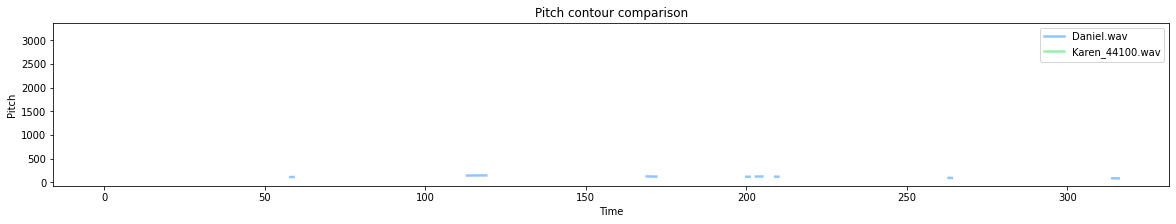

In [10]:
import matplotlib.pyplot as plt

# plot both pitches
plt.style.use('seaborn-pastel')
plt.figure(figsize=(20, 3))
#plt.plot(m_times, m_pitches, linewidth=2.5, label="model")
#plt.plot(r_times, r_pitches, linewidth=2.5, label="rec")
plt.plot(m_pitches, linewidth=2.5, label=filename2)
plt.plot(r_pitches, linewidth=2.5, label=filename1)

plt.xlabel('Time')
plt.ylabel('Pitch')
plt.title('Pitch contour comparison')

plt.legend();

In [11]:
# use YAAPT instead


# https://medium.com/@neurodatalab/pitch-tracking-or-how-to-estimate-the-fundamental-frequency-in-speech-on-the-examples-of-praat-fe0ca50f61fd

# http://bjbschmitt.github.io/AMFM_decompy/pYAAPT.html#quick-start

import amfm_decompy.pYAAPT as pYAAPT
import amfm_decompy.basic_tools as basic

signal = basic.SignalObj(filename1)
pitches = pYAAPT.yaapt(signal, f0_min=50.0, f0_max=500.0, frame_length=40, tda_frame_length=40, frame_space=5)
# pitches.set_values(pitches.samp_values, len(pitches.values), interp_tech='spline')
# plt.plot(pitches.values, linewidth=2.5, label=filename2, color="red")
pitches = pitches.samp_values
start = np.argmax(pitches > 0) # find index of first >0 sample
pitches = pitches[start:] # remove anything before that index
r_pitches = np.ma.masked_where(pitches <= 0, pitches) # mask 0 pitches (confidence was too low)

signal = basic.SignalObj(filename2)
pitches = pYAAPT.yaapt(signal, f0_min=50.0, f0_max=500.0, frame_length=40, tda_frame_length=40, frame_space=5)
# pitches.set_values(pitches.samp_values, len(pitches.values), interp_tech='spline')
# plt.plot(pitches.values, linewidth=2.5, label=filename2, color="green")
pitches = pitches.samp_values
start = np.argmax(pitches > 0)
pitches = pitches[start:]
m_pitches = np.ma.masked_where(pitches <= 0, pitches)



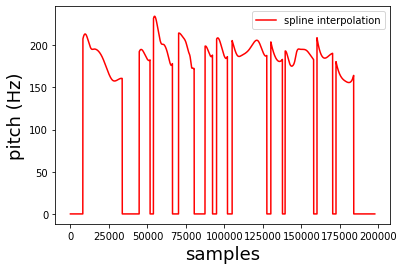

In [12]:
# YAAPT Experiment

import amfm_decompy.pYAAPT as pYAAPT
import amfm_decompy.basic_tools as basic

signal = basic.SignalObj(filename1)

pYAAPT.PitchObj.PITCH_DOUBLE = 2      # set new values
pYAAPT.PitchObj.PITCH_HALF = 2
pYAAPT.PitchObj.SMOOTH_FACTOR = 5

pitches = pYAAPT.yaapt(signal)

# plt.plot(pitches.values, label='pchip interpolation', color='green')

pitches.set_values(pitches.samp_values, len(pitches.values), interp_tech='spline')
plt.plot(pitches.values, label='spline interpolation', color='red')

pitches.set_values(pitches.samp_values, len(pitches.values), interp_tech='step')
# plt.plot(pitches.values, label='step interpolation', color='blue')

# plt.figure(figsize=(25, 3))
plt.xlabel('samples', fontsize=18)
plt.ylabel('pitch (Hz)', fontsize=18)
plt.legend(loc='upper right')
# axes = plt.gca()
# axes.set_xlim([0,100000])
# axes.set_ylim([150,250])
# plt.plot(m_pitches, linewidth=2.5, label=filename2)
# plt.plot(r_pitches, linewidth=2.5, label=filename1)

plt.show()


In [ ]:
# 0 center both lines
m_pitches -= m_pitches.mean()
r_pitches -= r_pitches.mean()


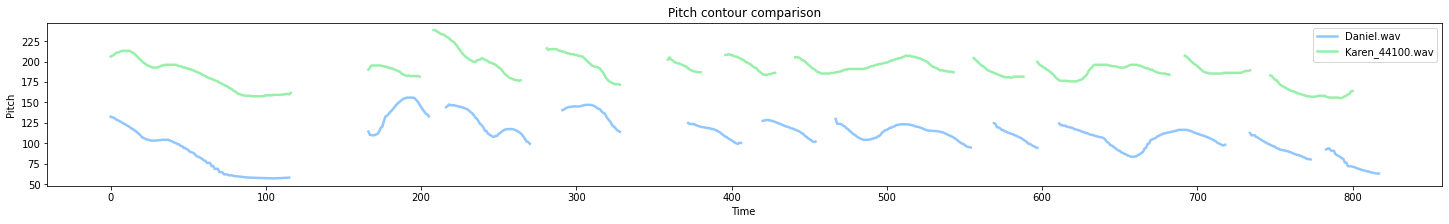

In [13]:
import matplotlib.pyplot as plt

# plot both pitches
plt.style.use('seaborn-pastel')
plt.figure(figsize=(25, 3))
#plt.plot(m_times, m_pitches, linewidth=2.5, label="model")
#plt.plot(r_times, r_pitches, linewidth=2.5, label="rec")
plt.plot(m_pitches, linewidth=2.5, label=filename2)
plt.plot(r_pitches, linewidth=2.5, label=filename1)

plt.xlabel('Time ')
plt.ylabel('Pitch ')
plt.title('Pitch contour comparison')

plt.legend();


dtw distance: 98892.24098181991
dtw normalized distance: 56.50985198961138


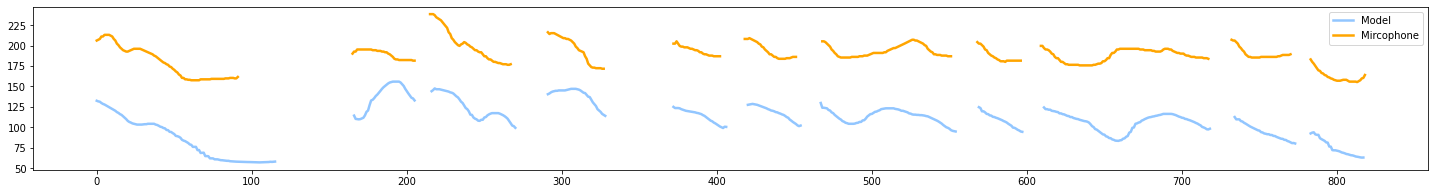

In [23]:
# run dynamic time warping (DTW)
import numpy as np
import matplotlib.pyplot as plt
import dtwalign


plt.figure(figsize=(25, 3))

# np.seterr(divide = 'ignore') 
# np.seterr(invalid = 'ignore') 
res = dtwalign.dtw(m_pitches, r_pitches, step_pattern="symmetricP2")

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

# warp r_pitches to m_pitches
r_pitches_warping_path = res.get_warping_path(target="reference")
plt.plot(m_pitches, linewidth=2.5, label="Model")
plt.plot(r_pitches[r_pitches_warping_path], linewidth=2.5, label="Mircophone", color="orange")
plt.legend()
plt.show()